# Modeling

## Overview

From the initial EDA, we learned of a few interesting relationships:
<br>
<br>1. Negative linear relationship between temperature and gas usage
<br>2. (Somewhat) Linear relationship between gas usage, temperature, and PM10 particulate occurance
<br>3. Cyclic behaviour in generation of gas, electricity, and PM10 particulate occurance
<br><br>
We will explore these relationships in hopes of creating accurate models to predict behaviours in related data points.

## Temperature and Gas Usage: Linear Regression

The first relationship we will explore is between temperature and gas usage. In the initial EDA, we saw quite a linear relationship, and the heatmap suggested that the correlation between these data is the strongest. Thus, we will focus on *linear regression* to predict gas usage based on the temperatures across the different provinces.

### Import extensions and data

In [1]:
# Extensions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import date
%matplotlib inline

In [2]:
# Modeling 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn import metrics
#from sklearn.metrics import precision_score, recall_score

In [3]:
# Electricity and Gas
df = pd.read_excel('Data/Korea_Electricity_and_Gas.xlsx')

# Gas
locs = list(range(0,3)) + list(range(19,35))
gas = df.iloc[:,locs]
gas

,Year,Month,Temperature,Gangwondo_Gas,Gyeonggido_Gas,Gyeongsangnamdo_Gas,Gyeongsangbukdo_Gas,Jeollanamdo_Gas,Jeollabukdo_Gas,Jeju_Gas,Chungcheongnamdo_Gas,Chungcheongbukdo_Gas,Seoul_Gas,Incheon_Gas,Gwangju_Gas,Daegu_Gas,Daejeon_Gas,Busan_Gas,Ulsan_Gas
0,2000,1,-1.20,16219,363014,42129,55362,22508,34507,0,20158,27838,662424,139454,39465,86077,52992,85787,69241
1,2000,2,-0.99,16280,375937,42604,52863,22310,33784,0,23492,27175,689177,145834,40674,84069,53950,87282,70910
2,2000,3,6.64,14105,323145,35990,47282,18033,29315,0,21156,22904,566528,121324,34610,76144,41898,74476,63627
3,2000,4,12.11,10364,237437,28698,40393,15920,19783,0,17447,16818,396231,91421,25898,62514,28618,58316,47106
4,2000,5,17.59,6843,169495,21073,35083,13808,14375,0,14508,12299,262940,67239,18426,46992,17503,45915,43749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,19076,255222,60523,84646,49039,43885,1506,70181,49460,163032,70646,27561,45058,31906,70508,94251
248,2020,9,21.40,18822,243817,65264,88652,54253,48190,1179,86971,53589,147556,72542,28120,43042,30307,70849,101433
249,2020,10,14.90,25946,339823,75071,103757,60416,61328,1414,109095,61315,213556,78654,39428,44555,42001,85283,119332
250,2020,11,9.00,35632,497221,101609,135432,68793,82360,2161,142556,82499,375289,115663,58120,67054,69624,122943,147792


In [4]:
gas['DATE'] = pd.to_datetime(gas[['Year', 'Month']].assign(DAY=1))
gas.DATE

0     2000-01-01
1     2000-02-01
2     2000-03-01
3     2000-04-01
4     2000-05-01
         ...    
247   2020-08-01
248   2020-09-01
249   2020-10-01
250   2020-11-01
251   2020-12-01
Name: DATE, Length: 252, dtype: datetime64[ns]

In [5]:
# Weather (Temperature)
weather = pd.read_excel('Data/Weather.xlsx')
weather

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongnamdo,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
0,2000,1,-1.20,-3.0,-2.1,3.3,2.7,1.0,0.8,6,-,-1.2,-2.1,-1.5,1.0,1.1,-1.2,4.2,3.1
1,2000,2,-0.99,-3.2,-1.7,3.0,2.3,0.6,0.2,4.6,-,-1.6,-1.7,-1.2,0.6,1.3,-1.1,3.2,2.7
2,2000,3,6.64,4.9,6.3,8.9,8.9,6.9,6.9,9.4,-,5.7,6.3,6.0,6.9,7.9,6.1,9.1,8.7
3,2000,4,12.11,10.8,11.9,13.4,13.9,12.6,12.8,13.5,-,11.5,11.9,11.5,12.6,13.0,11.9,13.2,13.6
4,2000,5,17.59,16.7,17.5,17.9,18.7,17.8,18.2,17.2,-,17.2,17.5,16.5,17.8,19.5,17.2,17.3,18.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2020,8,27.00,26.1,26.5,27.5,28.6,27.6,27.7,29.4,26.8,27.7,26.5,25.9,27.6,28.6,27.5,27.2,27.6
248,2020,9,21.40,19.7,21.4,21.5,21.6,21.3,21.3,22.9,20.7,21.5,21.4,21.3,21.3,21.2,21.2,21.9,21.1
249,2020,10,14.90,11.9,14.3,16.0,16.4,15.7,14.9,18.4,13.2,14.5,14.3,14.8,15.7,15.4,14.2,17.3,15.9
250,2020,11,9.00,6.1,8.0,10.7,11.3,10.5,9.6,14.1,8.1,8.8,8.0,8.3,10.5,9.7,8.6,12.4,11.0


Note that there are missing values in the 'Chungcheongnamdo' column of the temperature data. However, the two dataframes are the same size 252 rows x 19 columns (with an additional DATE row added to the gas dataframe).

### Dealing with missing values

In the gas dataset, the 'Jeju' column has many 0 values, which aren't necessarily expected, but could just be a replacement for unknown values. We will leave it for now.

In [6]:
gas.isnull().sum()

Year                    0
Month                   0
Temperature             0
Gangwondo_Gas           0
Gyeonggido_Gas          0
Gyeongsangnamdo_Gas     0
Gyeongsangbukdo_Gas     0
Jeollanamdo_Gas         0
Jeollabukdo_Gas         0
Jeju_Gas                0
Chungcheongnamdo_Gas    0
Chungcheongbukdo_Gas    0
Seoul_Gas               0
Incheon_Gas             0
Gwangju_Gas             0
Daegu_Gas               0
Daejeon_Gas             0
Busan_Gas               0
Ulsan_Gas               0
DATE                    0
dtype: int64

On the other hand, the weather dataframe has several '-' values, used to represent unknown data as well! Let's see the scale of unknown values.

In [7]:
(weather == '-').sum()

Year                  0
Month                 0
Overall               0
Gangwondo             0
Gyeonggido            0
Gyeongsamnamdo        0
Gyeongsambukdo        0
Jeollanamdo           0
Jeollabukdo           0
Jeju                  2
Chungcheongnamdo    204
Chungcheongbukdo      0
Seoul                 0
Incheon               0
Gwangju               0
Daegu                 0
Daejeon               0
Busan                 0
Ulsan                 0
dtype: int64

Here, we can see that there are 204 unknown values in the 'Chungcheongnamdo' column (out of 252 rows). There is <b>too much missing data here</b>, so for now we will just <b>remove the province</b> from our considerations. There are also 2 unknown values for 'Jeju', but since they are so few, we can just use an *average temperature to replace these values*.

In [8]:
# Remove the Chungcheongnamdo column from both dataframes
weather = weather.drop(columns='Chungcheongnamdo')
gas = gas.drop(columns='Chungcheongnamdo_Gas')

In [9]:
weather[weather.Jeju == '-']

,Year,Month,Overall,Gangwondo,Gyeonggido,Gyeongsamnamdo,Gyeongsambukdo,Jeollanamdo,Jeollabukdo,Jeju,Chungcheongbukdo,Seoul,Incheon,Gwangju,Daegu,Daejeon,Busan,Ulsan
204,2017,1,-0.35,-3.0,-1.8,2.6,2.9,2.0,0.8,-,-0.8,-1.8,-0.9,2.0,1.1,-0.4,4.1,2.8
213,2017,10,16.57,13.9,16.4,17.5,17.5,17.0,16.0,-,15.9,16.4,15.7,17.0,16.2,15.4,18.1,17.0


We can see here that the two missing values in 'Jeju' are from January and October of 2017. We'll replace these values with the average temperature in Jeju for these months.

In [10]:
# Create replacement value for January and October
january = weather[weather.Month == 1]
jeju_january = january['Jeju'].drop(index=204)
jeju_january_replace = jeju_january.mean()

october = weather[weather.Month == 10]
jeju_october = october['Jeju'].drop(index=213)
jeju_october_replace = jeju_october.mean().round(2)

print(jeju_january_replace, jeju_october_replace)

6.03 18.72


In [11]:
# Replace:
weather.loc[204,'Jeju']=jeju_january_replace
weather.loc[213,'Jeju']=jeju_october_replace
(weather == '-').sum()

Year                0
Month               0
Overall             0
Gangwondo           0
Gyeonggido          0
Gyeongsamnamdo      0
Gyeongsambukdo      0
Jeollanamdo         0
Jeollabukdo         0
Jeju                0
Chungcheongbukdo    0
Seoul               0
Incheon             0
Gwangju             0
Daegu               0
Daejeon             0
Busan               0
Ulsan               0
dtype: int64

### Normalize Data
Let's define a function to normalize the varying data (temperature, gas output, pollutant presence, etc). We will be using this for each region eventually, so it will be useful to have.

In [12]:
def normalize(df):
    for column in df.columns:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min()) 
    return df

And we use this function to normalize values in our dataframes. This will let us see the impact and error in a more understandable way. We can also later compare the error of using this feature in Linear Regression to later error.

In [13]:
weather_norm = normalize(weather)
gas_norm = normalize(gas)

### Split data to test and training sets
Split data into training and testing data, with an 80/20 split. Since we have multiple provinces and cities, we can separately train models for each. However, let's first try to train a model using only the 'Gyeonggido' province data.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(weather_norm.Gyeonggido, gas_norm.Gyeonggido_Gas, test_size=0.3)

In [15]:
print(X_train.shape, y_train.shape)
X_train.head()

(176,) (176,)


9      0.613889
221    0.841667
214    0.355556
222    0.972222
25     0.280556
Name: Gyeonggido, dtype: float64

### Deploying and evaluating Ordinary Least Squares Linear Regression Model

In [16]:
linReg = LinearRegression()
linReg.fit(X_train.array.reshape(-1,1), y_train)

LinearRegression()

In [17]:
y_pred = linReg.predict(X_test.array.reshape(-1,1))
print(linReg.intercept_, linReg.coef_)

0.7790405382759407 [-0.75511372]


In [18]:
rss = np.sum((y_test - y_pred)**2)
ess = np.sum((y_pred - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.804


In [19]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  1025.5


In [20]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMS Error:  0.10254005226686325


In [21]:
import statsmodels.formula.api as smf

In [22]:
smlin = smf.ols(formula='Temperature ~ Gyeonggido_Gas', data=gas).fit()
smlin.params
print(smlin.summary())

                            OLS Regression Results                            
Dep. Variable:            Temperature   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     847.9
Date:                Sun, 02 Jul 2023   Prob (F-statistic):           2.71e-82
Time:                        22:32:24   Log-Likelihood:                 151.81
No. Observations:                 252   AIC:                            -299.6
Df Residuals:                     250   BIC:                            -292.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9129      0.015     61.

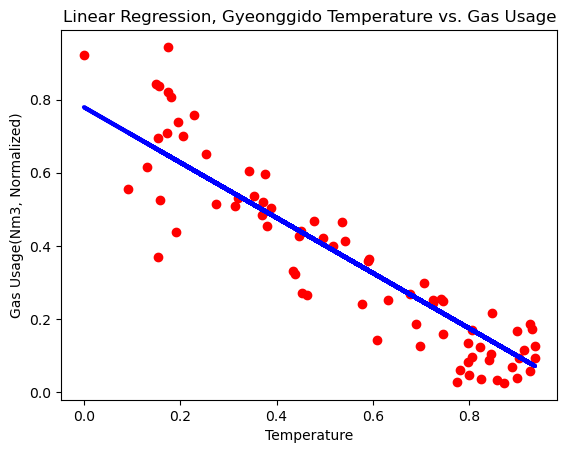

In [23]:
plt.scatter(X_test, y_test, color='r')
plt.plot(X_test, y_pred, color='b', linewidth=3)
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3, Normalized)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');

Here, we see how the model fits to our data, and is able to predict with a <b>RMSE of about 0.1</b>. This isn't great, but as we can see on the graph as well, it generally does fit the data. Let's try to see if we can do better with a different Linear Regression Model!

### Gradient Descent Linear Regression Model

In [24]:
from sklearn import linear_model
linReg2 = linear_model.SGDRegressor(max_iter=1000, tol=1e-5, random_state=0)
linReg2.fit(X_train.array.reshape(-1,1), y_train)

SGDRegressor(random_state=0, tol=1e-05)

In [25]:
y_pred2 = linReg2.predict(X_test.array.reshape(-1,1))
print(linReg2.intercept_, linReg2.coef_)

[0.70468014] [-0.63027716]


In [26]:
rss = np.sum((y_test - y_pred2)**2)
ess = np.sum((y_pred2 - np.mean(y_test))**2)
r2 = (ess/(ess + rss)).round(3)
print('R-Squared value for the model: ', r2)

R-Squared value for the model:  0.696


In [27]:
fstat = ((r2/(1-r2))*250).round(1)
print('F-stat value for the model: ', fstat)

F-stat value for the model:  572.4


In [28]:
print("RMS Error: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred2)))

RMS Error:  0.11429480040049524


We also tried using Gradient Descent to fit a linear regression to the data, but the RMSE is similar (perhaps even a little worse in this case), with a value of <b>RMSE=~0.13</b>.
<br>
The models are shown below:

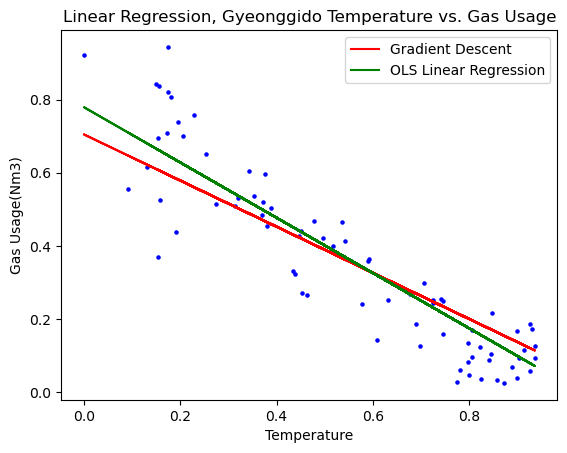

In [29]:
plt.scatter(X_test, y_test, color='b', s=5)
plt.plot(X_test, y_pred2, color='red', label='Gradient Descent')
plt.plot(X_test, y_pred, color='green', label='OLS Linear Regression')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Gas Usage(Nm3)')
plt.title('Linear Regression, Gyeonggido Temperature vs. Gas Usage');

## Initial Takeaway
From using these two types of linear regression (albeit without much tuning), we can see a decently useful relationship between temperature and gas usage. <b>The models both have an error of about 0.1</b>, but we can do better! Let's try with some other models.


## Cleaned Dataset and training with other models
As shown in the EDA, some other features may not be as suitable for a linear regression model. Let's try a different model, adding in some other potentially impactful features!
<br><br>
<u>The additional features we will include are:</u>
<br>1. Carbon Monoxide
<br>2. Nitrogen Dioxide
<br>3. Ozone
<br>4. Sulfuric Acid Gas
<br>5. PM10
<br><br>We will use these new features, along with the already present temperature, to predict gas generation in Normalized cubic meters (Nm3).

We can read in the information from the cleaned 'Korea_Data_All' excel file, which contains all of the additional features we've discussed. It is also cleaned up (missing values, year differences, missing regional values) in the way that we've discussed prior, in both this notebook and the initial EDA.

In [31]:
gyeonggi_full = pd.read_excel('Data/Korea_Data_All.xlsx',sheet_name=2)
gyeonggi_full

,Year,Month,Gyeonggido_Elec,Gyeonggido_Gas,Gyeonggi_PM10,Gyeonggi_Ozone,Gyeonggi_SO3,Gyeonggi_NO2,Gyeonggi_CO,Gyeonggido_Temp
0,2010,1,744.101205,738025,68,0.011,0.008,0.040,0.9,-4.5
1,2010,2,713.740016,610984,56,0.015,0.007,0.034,0.7,1.4
2,2010,3,731.995382,500288,67,0.023,0.005,0.028,0.6,4.3
3,2010,4,817.928450,439879,57,0.026,0.005,0.030,0.5,9.5
4,2010,5,700.898429,298335,66,0.033,0.005,0.029,0.5,17.2
...,...,...,...,...,...,...,...,...,...,...
127,2020,8,6047.920142,255222,24,0.023,0.003,0.011,0.3,26.5
128,2020,9,6285.545956,243817,22,0.029,0.003,0.013,0.4,21.4
129,2020,10,5805.792953,339823,38,0.022,0.003,0.022,0.5,14.3
130,2020,11,5313.923434,497221,45,0.017,0.003,0.027,0.5,8.0


In [32]:
print(gyeonggi_full.isna().sum())
(gyeonggi_full == '-').sum()

Year               0
Month              0
Gyeonggido_Elec    0
Gyeonggido_Gas     0
Gyeonggi_PM10      0
Gyeonggi_Ozone     0
Gyeonggi_SO3       0
Gyeonggi_NO2       0
Gyeonggi_CO        0
Gyeonggido_Temp    0
dtype: int64


Year               0
Month              0
Gyeonggido_Elec    0
Gyeonggido_Gas     0
Gyeonggi_PM10      0
Gyeonggi_Ozone     0
Gyeonggi_SO3       0
Gyeonggi_NO2       0
Gyeonggi_CO        0
Gyeonggido_Temp    0
dtype: int64

### Normalize full dataset data

In [33]:
gyeonggi_norm = gyeonggi_full.copy()
gyeonggi_norm = normalize(gyeonggi_norm.drop(columns=['Year', 'Month']))
gyeonggi_norm

,Gyeonggido_Elec,Gyeonggido_Gas,Gyeonggi_PM10,Gyeonggi_Ozone,Gyeonggi_SO3,Gyeonggi_NO2,Gyeonggi_CO,Gyeonggido_Temp
0,0.002289,0.818530,0.696970,0.026316,1.0,0.90625,1.000000,0.075000
1,0.001870,0.629182,0.515152,0.131579,0.8,0.71875,0.666667,0.238889
2,0.002122,0.464195,0.681818,0.342105,0.4,0.53125,0.500000,0.319444
3,0.003309,0.374158,0.530303,0.421053,0.4,0.59375,0.333333,0.463889
4,0.001693,0.163194,0.666667,0.605263,0.4,0.56250,0.333333,0.677778
...,...,...,...,...,...,...,...,...
127,0.075536,0.098936,0.030303,0.342105,0.0,0.00000,0.000000,0.936111
128,0.078818,0.081938,0.000000,0.500000,0.0,0.06250,0.166667,0.794444
129,0.072193,0.225030,0.242424,0.315789,0.0,0.34375,0.333333,0.597222
130,0.065400,0.459624,0.348485,0.184211,0.0,0.50000,0.333333,0.422222


Let's separate our target and features. We will try predicting the generated gas (Nm3) from the pollutants and temperature, so the gas will be the target.

Since we initially tried using simple linear regression with only the temperature as a feature, let's also try doing the same with random forest.

## Random Forest Regression: Temperature
Using a random forest model, let's first see how the model handles using a singular feature and target: temperature and gas.

In [34]:
# separating training and test data with only temperature and gas
X_train, X_test, y_train, y_test = train_test_split(gyeonggi_norm.Gyeonggido_Temp, gyeonggi_norm.Gyeonggido_Gas, test_size=.3, random_state=17)

Initialize the regressor (basic random forest). We need to reshape the X_train and X_test, as we're only using a single feature in this model.

In [35]:
# initialize regressor
X_train = X_train.array.reshape(-1,1)
X_test = X_test.array.reshape(-1,1)
forest = RandomForestRegressor(random_state=42)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

### Calculating Error
For regression problems, we can focus on error values like Mean Squared Error and Root Mean Squared Error to see how well our model is performing in comparison to the actual target values.

In [36]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (One Feature Random Forest): ', mse)
print('RMSE (One Feature Random Forest): ', rmse)

MSE (One Feature Random Forest):  0.003728632207038477
RMSE (One Feature Random Forest):  0.0610625270279447


The error is not too bad, as our values are between 0 and 1 (normalized), and the error is <1e-1 even in the RMSE case.
<br>
However, let's see if adding more features can help improve the results.

## Random Forest Regression: All Features
Now, we can compare the effectiveness of a model with all of the pollutant data included as features, instead of only using a single temperature feature.

In [37]:
# Separate target and features
target = gyeonggi_norm.Gyeonggido_Gas
features = gyeonggi_norm.drop(columns='Gyeonggido_Gas')

In [38]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=17)

In [39]:
# initialize regressor
forest = RandomForestRegressor(random_state=42)
forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

### Calculating Error

In [40]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Basic Random Forest): ', mse)
print('RMSE (Basic Random Forest): ', rmse)

MSE (Basic Random Forest):  0.0028854058740435885
RMSE (Basic Random Forest):  0.05371597410494935


We can already see some improvement! Both errors have reduced significantly.

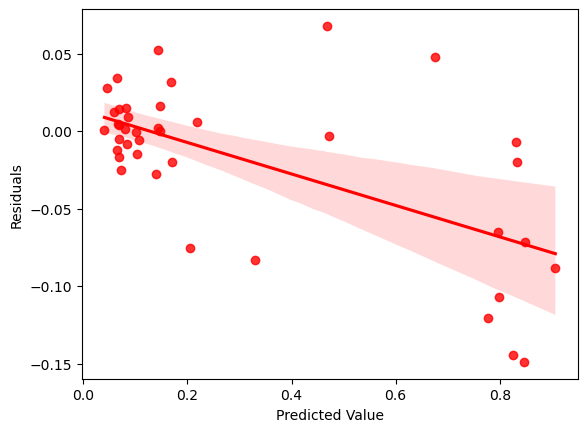

In [44]:
# plot of residuals vs predicted values
sns.regplot(y=np.subtract(y_test, y_pred), x=y_pred, scatter=True, color='r')
plt.xlabel('Predicted Value')
plt.ylabel('Residuals');

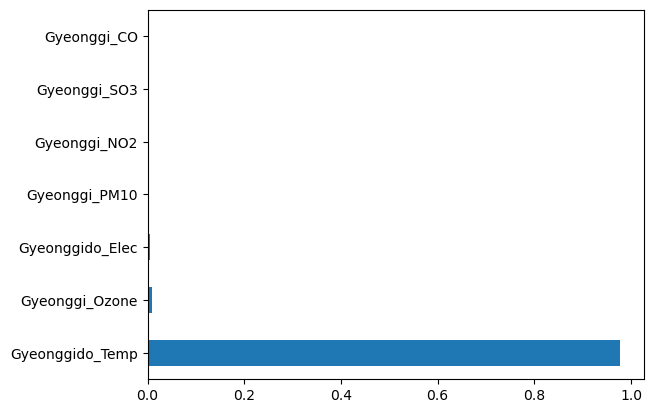

In [45]:
importances = pd.Series(forest.feature_importances_, index=X_train.columns)
importances.nlargest(7).plot(kind='barh')
plt.show()

### Tuning the regressor
Grid search to find general good parameter areas

In [46]:
# define models and parameters
model = RandomForestRegressor()
grid = {
    'n_estimators': [10,100,200,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [6,7,8,9],
    'random_state': [42]
}

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [167]:
# define grid search
search = GridSearchCV(model, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# start grid search
result = search.fit(features, target)

In [168]:
print(result.best_score_)
print(result.best_params_)

-0.005479685446876429
{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}


Let's see how it performs on the data we previously used:

In [47]:
# initialize again, with tuned hyperparameters
forest_tuned = RandomForestRegressor(max_depth=8, max_features='sqrt', n_estimators=100, random_state=42)
forest_tuned = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

Once again calculating the error:

In [48]:
mse_tuned = mean_squared_error(y_test, y_pred)
rmse_tuned = mse_tuned**.5
print('MSE (Tuned Random Forest): ', mse_tuned)
print('RMSE (Tuned Random Forest): ', rmse_tuned)
print('MSE (Basic Random Forest): ', mse)
print('RMSE (Basic Random Forest): ', rmse)

MSE (Tuned Random Forest):  0.0027270373109823678
RMSE (Tuned Random Forest):  0.05222104279868765
MSE (Basic Random Forest):  0.0028854058740435885
RMSE (Basic Random Forest):  0.05371597410494935


We can also use the regressor to see what features had the greatest impact.

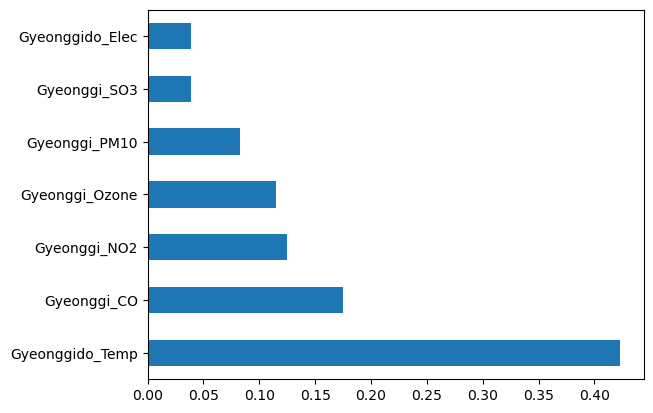

In [49]:
importances = pd.Series(forest_tuned.feature_importances_, index=X_train.columns)
importances.nlargest(7).plot(kind='barh')
plt.show()

### Results
Just from this quick grid search tuning, we can see a slight decrease in error for both MSE and RMSE. Our final error values for the random forest are: 
<br>
<b>MSE: 0.0027
<br>
RMSE: 0.052</b>
<br><br>
If we compare to the RMSE values of using linear regression models, we can already see a significant improvement (0.1 -> 0.05)!

## Decision Tree: All features
Let's try one more model type: decision tree. We'll try again with all the features and see how it compares to our tuned random forest model.

In [50]:
# import and initialize regressor
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(random_state=42)
dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)

In [51]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Basic Decision Tree): ', mse)
print('RMSE (Basic Decision Tree): ', rmse)

MSE (Basic Decision Tree):  0.004235449530555132
RMSE (Basic Decision Tree):  0.06508033136482275


In [52]:
model2 = DecisionTreeRegressor()
parameters={
    'max_depth': [1,3,5,7,9],
    'max_features': ['auto', 'log2', 'sqrt'],
    'min_samples_leaf': [2,3,4,5,6],
    'splitter': ['best', 'random'],
    'random_state': [42]
}

In [124]:
search2 = GridSearchCV(model2, parameters, scoring='neg_mean_squared_error', cv=cv)

result2 = search2.fit(features, target)

In [125]:
print(result2.best_score_)
print(result2.best_params_)

-0.0031672984474570404
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 5, 'random_state': 42, 'splitter': 'best'}


In [53]:
# initialize again, with tuned hyperparameters
tree_tuned = DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=5, random_state=42, splitter='best')
tree_tuned = tree_tuned.fit(X_train, y_train)
y_pred = tree_tuned.predict(X_test)

In [54]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned Decision Tree): ', mse)
print('RMSE (Tuned Decision Tree): ', rmse)

MSE (Tuned Decision Tree):  0.003135497565865103
RMSE (Tuned Decision Tree):  0.05599551380124218


### Comparing Decision Tree to Random Forest:
Here we can see that our random forest (both tuned and untuned) performed better than the decision tree model. Moving forward, we will thus focus on using __random forest__ as our model.

## KNN Algorithm Regression

In [55]:
from sklearn import neighbors 
from math import sqrt

In [56]:
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    KNN_model = neighbors.KNeighborsRegressor(n_neighbors = K)

    KNN_model.fit(X_train, y_train)  #fit the model
    y_pred=KNN_model.predict(X_test) #make prediction on test set
    RMSE = sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
    rmse_val.append(RMSE) #store rmse values

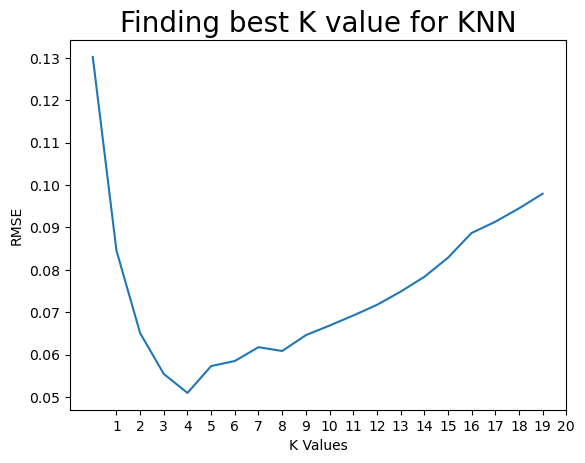

In [57]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot(legend=None)
plt.title('Finding best K value for KNN', size=20)
plt.xlabel('K Values')
plt.ylabel('RMSE')
plt.xticks(range(1, 21));

The elbow clearly occurs at __K = 4__, so we'll use that information for our best choice of regressor.

In [59]:
mse = rmse_val[3]**2
print('KNN, k=4 MSE:', mse)
print('KNN, k=4 RMSE:', rmse_val[3])

KNN, k=4 MSE: 0.0030750960179721206
KNN, k=4 RMSE: 0.05545354829018717


## Try again with less features
As we saw from the importances plot, electricity generation and SO3 are the least impactful here. Let's see if removing them improves performance. Random Forest was our best performer so we can try again with that.

In [60]:
X_test = X_test.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3'])
X_train = X_train.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3'])
y_test = y_test.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3'])
y_train = y_train.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3'])

In [61]:
forest_tuned = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

In [62]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned, Dropped Value Random Forest): ', mse)
print('RMSE (Tuned, Dropped Value Random Forest): ', rmse)

MSE (Tuned, Dropped Value Random Forest):  0.002313052443184661
RMSE (Tuned, Dropped Value Random Forest):  0.048094203841883704


This actually performed better than before! Let's see if removing the next lowest importance feature continues to imporve performance. The next one is PM10.

In [63]:
X_test = X_test.drop(columns=['Gyeonggi_PM10'])
X_train = X_train.drop(columns=['Gyeonggi_PM10'])

In [64]:
forest_tuned = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

In [65]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned, Dropped Value Random Forest): ', mse)
print('RMSE (Tuned, Dropped Value Random Forest): ', rmse)

MSE (Tuned, Dropped Value Random Forest):  0.0019864144531770676
RMSE (Tuned, Dropped Value Random Forest):  0.04456920969881638


Again, this further improved the performance! Let's try one more time:

In [66]:
X_test = X_test.drop(columns=['Gyeonggi_Ozone'])
X_train = X_train.drop(columns=['Gyeonggi_Ozone'])

In [67]:
forest_tuned = forest_tuned.fit(X_train, y_train)
y_pred = forest_tuned.predict(X_test)

In [68]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned, Dropped Value Random Forest): ', mse)
print('RMSE (Tuned, Dropped Value Random Forest): ', rmse)

MSE (Tuned, Dropped Value Random Forest):  0.0032332469259944868
RMSE (Tuned, Dropped Value Random Forest):  0.05686164723251066


We can see here that the performance has gone back down. Let's try to use this information and retune and build another random forest model.

### Best Features:
We got the best results by removing Electricity generation, SO3, and PM10.
<br> MSE: 0.00199
<br> RMSE: 0.0446

## Random Forest: Tuned, with removed features
Let's tune a random forest again, this time without PM10, SO3, and electricity features.

In [69]:
# define models and parameters
model3 = RandomForestRegressor()
grid = {
    'n_estimators': [200,400,500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [8,9,10],
    'random_state': [42]
}

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [70]:
features_dropped = features.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3', 'Gyeonggi_PM10'])

In [182]:
# define grid search
search3 = GridSearchCV(model3, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# start grid search
result3 = search3.fit(features_dropped, target)

In [183]:
print(result3.best_score_)
print(result3.best_params_)

-0.0034526940943149
{'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42}


We can already see that this performs better than the previous tuned model!

In [73]:
# reset the training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=17)

In [74]:
X_test = X_test.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3', 'Gyeonggi_PM10'])
X_train = X_train.drop(columns=['Gyeonggido_Elec', 'Gyeonggi_SO3', 'Gyeonggi_PM10'])

In [75]:
# initialize again, with tuned hyperparameters
forest_tuned2 = RandomForestRegressor(max_depth=9, max_features='sqrt', n_estimators=400, random_state=42)
forest_tuned2 = forest_tuned2.fit(X_train, y_train)
y_pred = forest_tuned2.predict(X_test)

In [76]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned, Feature Dropped Random Forest): ', mse)
print('RMSE (Tuned, Feature Dropped Random Forest): ', rmse)

MSE (Tuned, Feature Dropped Random Forest):  0.002107480006400584
RMSE (Tuned, Feature Dropped Random Forest):  0.04590729796449127


## Final results after removing features and tuning again:
Features: Ozone, NO2, CO, Temperature
<br> Model: Random Forest
<br> Hyperparams: 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42
<br> __MSE: 0.0021
<br> RMSE: 0.046__

# Selecting features with recursive feature elimination

In [77]:
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from numpy import mean
from numpy import std

In [78]:
# create pipeline
rfe = RFECV(estimator=RandomForestRegressor())
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

In [79]:
# report performance
print('MSE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

MSE: -0.003 (0.002)


In [80]:
rfe.fit(features, target)

RFECV(estimator=RandomForestRegressor())

In [81]:
for i in range(features.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000


In [82]:
selected = list(range(0,5)) + [6]
print('Selected features: ', *features.iloc[:,selected].columns, sep='\n')

Selected features: 
Gyeonggido_Elec
Gyeonggi_PM10
Gyeonggi_Ozone
Gyeonggi_SO3
Gyeonggi_NO2
Gyeonggido_Temp


According to the recursive selection, only CO should be removed.

In [83]:
from sklearn.feature_selection import RFE

In [84]:
rfe2 = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
# fit RFE
rfe2.fit(features, target)
# summarize all features
for i in range(features.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected True, Rank: 1.000
Column: 5, Selected False, Rank: 2.000
Column: 6, Selected True, Rank: 1.000


This is confirmed by manually specifying features to select, using an RFE.

In [102]:
# reset the training and test sets again
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=17)

In [103]:
forest_tuned3 = RandomForestRegressor()
forest_tuned3 = forest_tuned3.fit(X_train.drop(columns='Gyeonggi_CO'), y_train)
y_pred = forest_tuned3.predict(X_test.drop(columns='Gyeonggi_CO'))

In [104]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Untuned, RFE Random Forest): ', mse)
print('RMSE (Untuned, RFE Random Forest): ', rmse)

MSE (Untuned, RFE Random Forest):  0.0030742358026645306
RMSE (Untuned, RFE Random Forest):  0.05544579156856299


In [97]:
# define models and parameters
model3 = RandomForestRegressor()
grid = {
    'n_estimators': [100,200,400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [9,10,11],
    'random_state': [42]
}

# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [98]:
# define grid search
search4 = GridSearchCV(model3, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# start grid search
result4 = search4.fit(features.drop(columns='Gyeonggi_CO'), target)

In [99]:
print(result4.best_score_)
print(result4.best_params_)

-0.005030221023739017
{'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42}


In [105]:
forest_tuned4 = RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=200, random_state=42)
forest_tuned4 = forest_tuned4.fit(X_train.drop(columns='Gyeonggi_CO'), y_train)
y_pred = forest_tuned4.predict(X_test.drop(columns='Gyeonggi_CO'))

mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Tuned RFE Random Forest): ', mse)
print('RMSE (Tuned RFE Random Forest): ', rmse)

MSE (Tuned RFE Random Forest):  0.0023617172973290365
RMSE (Tuned RFE Random Forest):  0.048597502994794255


## Final Result after recursively eliminating features and re-tuning hyperparameters:
Features: Electricity Generation, PM10, Ozone, NO2, Temperature
<br> Model: Random Forest
<br> Hyperparams: 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 42
<br> __MSE: 0.0024
<br> RMSE: 0.049__
<br><br>
### Compared to the previous, manually eliminated features:
Features: Ozone, NO2, CO, Temperature
<br> Model: Random Forest
<br> Hyperparams: 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 400, 'random_state': 42
<br> __MSE: 0.0021
<br> RMSE: 0.046__

# Even more features... 
Let's introduce more potentially impactful features! This is explored in the EDA, but we will include additional weather data (precipitation, wind speed, etc.), travel data (international flights), and housing information (construction building use/material). 

In [107]:
gas_mega_df = pd.read_excel('Data/Korea_Data_All.xlsx', sheet_name='GAS_RELEVANT_GGDO')
gas_mega_df

,Year,Month,Gyeonggido_Elec,Gyeonggido_Gas,Gyeonggi_PM10,Gyeonggi_Ozone,Gyeonggi_SO3,Gyeonggi_NO2,Gyeonggi_CO,Gyeonggido_Temp,Seoul_Total_Precip_mm,Seoul_Mean_Wind_Speed,Seoul_Mean_Rel_Humidity,Seoul_Surgery_Cases,Nat_Total_New_Buildings,Nat_Masonry_Buildings,Nat_Industrial_Use_Buildings,Nat_Edu_Social_Use_Buildings,Nat_Other_Use_Buildings
0,2010,1,744.101205,738025,68,0.011,0.008,0.040,0.9,-4.5,29.3,2.3,65,164364,9528,627,1290,502,1964
1,2010,2,713.740016,610984,56,0.015,0.007,0.034,0.7,1.4,55.3,2.4,59,137825,10241,719,1196,422,2067
2,2010,3,731.995382,500288,67,0.023,0.005,0.028,0.6,4.3,82.5,2.9,59,164433,17168,1469,1771,769,3399
3,2010,4,817.928450,439879,57,0.026,0.005,0.030,0.5,9.5,62.8,2.9,54,148010,21082,1957,2200,920,4677
4,2010,5,700.898429,298335,66,0.033,0.005,0.029,0.5,17.2,124.0,2.6,62,140411,18084,1625,1726,856,3908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2020,8,6047.920142,255222,24,0.023,0.003,0.011,0.3,26.5,675.7,2.3,85,147117,13575,250,1277,437,3281
128,2020,9,6285.545956,243817,22,0.029,0.003,0.013,0.4,21.4,181.5,2.5,71,145354,16906,368,1364,478,4260
129,2020,10,5805.792953,339823,38,0.022,0.003,0.022,0.5,14.3,0.0,2.1,60,160605,16080,344,1201,531,4049
130,2020,11,5313.923434,497221,45,0.017,0.003,0.027,0.5,8.0,120.1,2.2,64,166500,16709,309,1315,501,4342


As we can see, there are a lot more features here with potential implications or benefits on building an even more accurate model. To reference the correlation heatmap from the EDA:

<div>
<img src="Data/feature_correlation_gas.png" width="800" height="400">
</div>

Let's try to run a simple Random Forest Regressor to see how it performs with all of these new features.

In [129]:
# define features and target (gas generation)
gas_norm_mega_df = normalize(gas_mega_df)
features = gas_norm_mega_df.drop(columns=['Gyeonggido_Gas', 'Month', 'Year'])
target = gas_norm_mega_df.Gyeonggido_Gas

In [130]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3, random_state=17)

In [131]:
# initialize regressor
final_forest = RandomForestRegressor(random_state=42)
final_forest = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [132]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Many Features Untuned Random Forest): ', mse)
print('RMSE (Many Features Untuned Random Forest): ', rmse)

MSE (Many Features Untuned Random Forest):  0.0022937211715045452
RMSE (Many Features Untuned Random Forest):  0.04789280918368169


This actually performs better than the initial untuned model from before with less features! Let's try to see if any features can be eliminated to better improve the performance. We can use another recursive feature elimination:

In [133]:
# create pipeline
rfe = RFECV(estimator=RandomForestRegressor())
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, features, target, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

In [134]:
rfe.fit(features, target)

RFECV(estimator=RandomForestRegressor())

In [135]:
for i in range(features.shape[1]):
 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected False, Rank: 7.000
Column: 1, Selected False, Rank: 4.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected False, Rank: 9.000
Column: 4, Selected False, Rank: 8.000
Column: 5, Selected False, Rank: 10.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected False, Rank: 3.000
Column: 8, Selected False, Rank: 2.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected True, Rank: 1.000
Column: 12, Selected True, Rank: 1.000
Column: 13, Selected False, Rank: 6.000
Column: 14, Selected False, Rank: 5.000
Column: 15, Selected True, Rank: 1.000


In [137]:
selected = [2, 6, 15] + list(range(9,13))
print('Selected features: ', *features.iloc[:,selected].columns, sep='\n')

Selected features: 
Gyeonggi_Ozone
Gyeonggido_Temp
Nat_Other_Use_Buildings
Seoul_Mean_Rel_Humidity
Seoul_Surgery_Cases
Nat_Total_New_Buildings
Nat_Masonry_Buildings


In [141]:
features_dropped = features.iloc[:,selected]

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(features_dropped, target, test_size=.3, random_state=17)

In [142]:
# initialize regressor
final_forest_dropped = RandomForestRegressor(random_state=42)
final_forest_dropped = forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = mse**.5
print('MSE (Less Features Untuned Random Forest): ', mse)
print('RMSE (Less Features Untuned Random Forest): ', rmse)

# Initial Modeling: Conclusion
### Target pivot: Pharmaceutical Sales
This notebook aimed to work with several algorithms/methods to find potential connections and make a model to predict electricity and/or gas generation in Korea based on the variety of data collected and discussed above. However, while working with the data and exploring correlations, it was found that there are convincing and interesting relationships to be explored with a different target in mind: _Predicting total pharmaceutical sales_. 

Therefore, this portion of data exploration and modeling will be put on pause, and these techniques will instead be used to find relationships in the data with regards to this new target. This will be continued in a new notebook file (Pharm_Modeling.ipynb) for clarity, and will also summarize previous findings and motivations for changing the target. 

This capstone project is very similar to a research project in nature, so the conclusions often shift depending on new findings in the data. Thank you for your interest thus far, and please continue in Pharm_Modeling to see the final conclusions of this project.